In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from photutils.segmentation import SourceCatalog
from photutils import SegmentationImage
import quicklook as jql
import jades_photutils_interface as jpui
import time
import os
import sep
from comet_ml import Experiment
import torch
from torchvision import models
from  astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import CenterCrop
from reproject.mosaicking import find_optimal_celestial_wcs
from dataset import SR_HST_HSC_Dataset
import generator
import torchvision.transforms.functional as TF
from typing import Tuple
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.nddata.utils import NoOverlapError
from tqdm import tqdm
from morpheus_core import morpheus_core

In [2]:
!ls ../../../../hsc_hst_data/data

Gaussian-Blur Subtraction.pdf
cutout-HSC-I-9813-pdr2_dud-210317-161628.fits
download_data
header.fits
hlsp_candels_hst_acs_cos-tot_f814w_v1.0_drz.fits
hst_to_hsc_footprint.fits
resized_hst_f814w.fits
sample_hsc.fits
sample_hst.fits
samples
samples.zip


#### Load HSC/HST - raw files can be found on Lux @ /data/groups/comp-astro/shkahn/super-resolution/hsc_hst_data/data

In [3]:
print("Opening data")
hst = fits.open("../../../../hsc_hst_data/data/resized_hst_f814w.fits")[0]
hsc = fits.open("../../../../hsc_hst_data/data/cutout-HSC-I-9813-pdr2_dud-210317-161628.fits")[1]

print("HST -> HSC")
# hst_on_hsc_array, hst_on_hsc_footprint = reproject_interp(hst, hsc.header)

Opening data
HST -> HSC


In [4]:
print(hst.header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                29999                                                  NAXIS2  =                77143                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H FILENAME= 'hlsp_candels_hst_hst_candels-v1.0_acs_f814w_drz.fits' / MAST HLSP FilCOMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CTYPE1  = 'RA---TAN'                                                            CTYPE2  = 'DEC--TAN'                                                            CRVAL1  =          150.1163213          

#### Create two overlapping HST/HSC Samples to compare Mosaics 

In [5]:
x,y=4000,4000
ra_hsc, dec_hsc = WCS(hsc.header).all_pix2world(x, y, 1) # Get RA/DEC of (x,y) for HSC
x_hst, y_hst = WCS(hst.header).all_world2pix(ra_hsc, dec_hsc, 1) # Get x/y for HST

hsc_sample = Cutout2D( 
    data=hsc.data,
    position=[x, y],
    # position=skycoord,
    size=600,
    wcs=WCS(hsc.header)
) # hsc cutout


hst_sample = Cutout2D(
    data=hst.data,
    position=[x_hst, y_hst],
    # position=skycoord,
    size=3600,
    wcs=WCS(hst.header),
) #hst cutout

#### Load SR Mosaic - files on Lux @ /data/groups/comp-astro/shkahn/super-resolution/hsc_hst_data/data


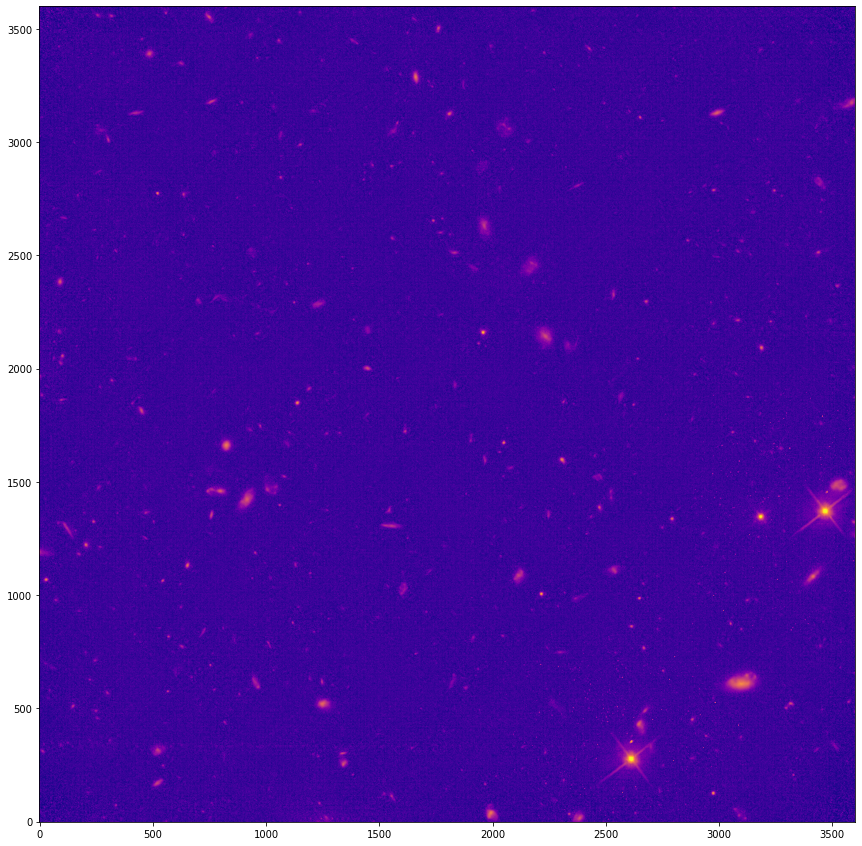

In [6]:
img = fits.getdata("morpheus-tests/output.fits")
n = fits.getdata("morpheus-tests/n.fits")
y,x = np.where(n>1)
means = img[y,x,0,0]
var = img[y,x,0,1]
draw = np.random.normal(means,np.sqrt(var))

mean_cop = img[:,:,0,0].copy() ## SR Mosaic

mean_cop[y,x] = draw
clipped_mean_var = np.clip(mean_cop,0,1)

f, axarr = plt.subplots(1,1,figsize=(15,15))
axarr.imshow(clipped_mean_var, 
               cmap="plasma", 
               origin="lower",
               norm=simple_norm(clipped_mean_var, stretch="log"))


#### Aperture Radii vs. Electron RMS

In [19]:
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils import SegmentationImage
from photutils.segmentation import detect_sources
# np.random.seed(666)
def rms_aperature_comp(data,seed=0):
    
    npos=100
    
    #get shape of image
    shape = data.shape

    mask = detect_sources(data,.006,5).data #hst segmap
    mask[mask>0] = 1
    np.random.seed(seed)
    #get random positions
    positions = np.zeros((npos,2))
    positions[:,0] = np.random.uniform(high=shape[0],size=npos)
    positions[:,1] = np.random.uniform(high=shape[1],size=npos)
    
    #linear pixels
    N_nmad_max = 35.0 #pixels >~1 arcsec max
    n_nmad = 40
    N_nmad_table = np.linspace(5,N_nmad_max,n_nmad)
    
    #radii
    A_nmad = N_nmad_table**2 #area in pixels**2
    r_nmad = (A_nmad / (np.pi))**0.5 #aperture radii in pixels
    
    #get apertures
    apertures = [CircularAperture(positions,r=r) for r in r_nmad]
    
    #what is the pixel variance?
    print(f"Pixel stddev = {np.nanstd(data*1)}")
    
    #perform photometry
    #phot_table = aperture_photometry(data_nmad * f_data_to_e, apertures, mask=mask)
    phot_table = aperture_photometry(data, apertures,mask=mask)
    # texp_table = aperture_photometry(data_texp, apertures)
    
    #record the sigmas and exposure times
    sigma_nmad_table = np.zeros(n_nmad)
    texp_nmad_table = np.zeros(n_nmad)
    t=6900
    #compute the std of the aperture fluxes x t_exposure
    for i in range(n_nmad):
        x = phot_table[f'aperture_sum_{i}']           #aperture flux
        sigma_nmad_table[i] = np.nanstd(x*t)          #RMS # of electrons
        texp_nmad_table[i]  = np.nanmean(t)           #mean of exposure times
        
    # #test
    np.savetxt("sample"+'.nmad', np.c_[N_nmad_table,sigma_nmad_table,texp_nmad_table])
    
    #fit a power law
    p = np.polyfit(np.log10(r_nmad),np.log10(sigma_nmad_table),1)
    print(f"NMAD fit normalization = {p[1]}, power law index = {p[0]}.")
    return sigma_nmad_table,r_nmad


sigma_nmad_table_hst,r_nmad_hst = rms_aperature_comp(hst_sample.data,seed=0)
sigma_nmad_table_sr,r_nmad_sr = rms_aperature_comp(mean_cop,seed=0)

Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.2931616591235418, power law index = 2.197493090282293.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 1.2514325053239155, power law index = 2.2309488181841908.


/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:

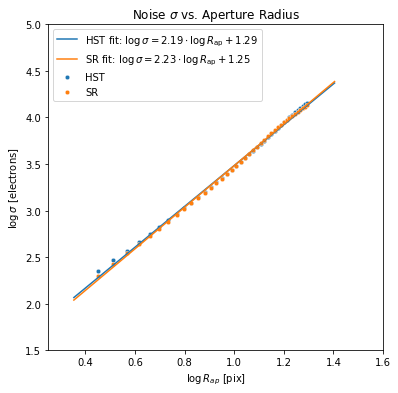

In [102]:
import seaborn as sns
plt.figure(figsize=(6,6))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
sns.scatterplot(np.log10(r_nmad_hst),np.log10(sigma_nmad_table_hst),label = "HST",s=20)
sns.scatterplot(np.log10(r_nmad_sr),np.log10(sigma_nmad_table_sr),label = "SR",s=20)
A_nmad =  np.linspace(4,45,100)**2 #area in pixels**2
r_nmad = (A_nmad / (np.pi))**0.5 #aperture radii in pixels
    
x = np.log10(r_nmad)
y = 2.19*x+1.2931616591235418

sns.lineplot(x,y,label=r"HST fit: $\log\sigma = 2.19\cdot\log R_{\rm{ap}}+1.29$")
y =  2.2309488181841908*x+ 1.2514325053239155
sns.lineplot(x,y,label=r"SR fit: $\log\sigma = 2.23\cdot\log R_{\rm{ap}}+1.25$")

plt.ylabel(r"$\log\sigma$ [electrons]")
plt.xlabel(r"$\log R_{ap}$ [pix]")
# # plt.xscale('log')
# # plt.yscale('log')
plt.title("Noise $\sigma$ vs. Aperture Radius")
plt.xlim(0.25,1.6)
plt.ylim(1.5,5)
plt.savefig("noise-properties.pdf",dpi=1000,bbox_inches='tight')
# r_nmad_hst

In [42]:
np.polyfit(r_nmad_hst,sigma_nmad_table_hst,1)

array([  839.38224747, -4298.51040685])

In [84]:
import random
hst_rms = list(map(lambda i:rms_aperature_comp(hst_sample.data,random.randint(0,5000000))[0],range(50)))

Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.484462819041773, power law index = 1.2982614685100866.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.2198050208868199, power law index = 2.0775233141423053.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.3311523649191277, power law index = 1.8380834134638764.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.1726032660158214, power law index = 1.852428017095921.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.6796158555709175, power law index = 2.067652595192022.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.2595579061256736, power law index = 1.5326470981726545.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.5833377162838984, power law index = 2.0624933296877144.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.3495222336712966, power law index = 1.6534211322015082.
Pixel stddev = 0.0842110887169838
NMAD fit normalization = 1.180136

In [85]:
sr_rms = list(map(lambda i:rms_aperature_comp(mean_cop,random.randint(0,5000000))[0],range(50)))

Pixel stddev = 0.0871206521987915
NMAD fit normalization = 0.6347439422011205, power law index = 2.4684563211171877.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 1.1070011226500116, power law index = 1.657058553408848.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 1.5784824032443574, power law index = 1.5744068162373097.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 1.1978333449065026, power law index = 1.6465733584436988.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 1.7158676486694364, power law index = 1.8212073873876113.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 1.3558936282074987, power law index = 1.7241995253838707.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 2.697287203486382, power law index = 1.3683138086385158.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 0.8631438902142655, power law index = 1.7431487606265552.
Pixel stddev = 0.0871206521987915
NMAD fit normalization = 0.52367

In [81]:
sr_rms

[array([  200.43128117,   268.54065184,   346.84556798,   434.77477632,
          531.9913128 ,   639.47004245,   762.9318593 ,   897.2303477 ,
         1038.4265164 ,  1192.87671668,  1365.53975683,  1550.59962274,
         1746.80937963,  1955.74099402,  2189.28567515,  2450.05246322,
         2726.38128529,  3028.57588436,  3358.872257  ,  3703.0735228 ,
         4052.88321173,  4434.36760252,  4865.30695681,  5318.42357251,
         5788.11352369,  6275.84317386,  6779.42900096,  7289.01561938,
         7811.21285107,  8343.04181358,  8882.25036004,  9415.41630939,
         9944.31441435, 10468.31099662, 10997.23971458, 11523.82851081,
        12050.85501633, 12580.63659161, 13094.87400308, 13594.90099748]),
 array([  87.38664463,  143.66399099,  155.57051498,  163.70545221,
         172.94668717,  181.75254266,  193.53285834,  207.89084922,
         222.43204262,  234.91773055,  249.46546396,  271.43609667,
         296.03371688,  322.49597485,  352.88228389,  382.01844454,
      

/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:

Text(0.5, 1.0, 'HST \\& SR Noise Profiles')

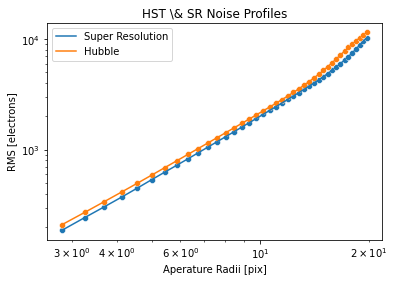

In [11]:

sns.scatterplot(r_nmad_hst,np.mean(np.array(sr_rms),axis=0))
sns.lineplot(r_nmad_sr,np.mean(np.array(sr_rms),axis=0),label="Super Resolution")
sns.scatterplot(r_nmad_hst,np.mean(np.array(hst_rms),axis=0))
sns.lineplot(r_nmad_hst,np.mean(np.array(hst_rms),axis=0),label="Hubble")
plt.ylabel("RMS [electrons]")
plt.xlabel("Aperature Radii [pix]")
plt.xscale('log')
plt.yscale('log')
plt.title("HST \& SR Noise Profiles")

In [12]:
frac_diff = (np.mean(np.array(sr_rms),axis=0)-np.mean(np.array(hst_rms),axis=0))/np.mean(np.array(hst_rms),axis=0)
sns.scatterplot(r_nmad_hst,frac_diff)
sns.lineplot(r_nmad_hst,frac_diff)
plt.ylabel(r"$\frac{SR-HST}{\rule{0pt}{0.75em}HST}$")
plt.xlabel("Aperature Radii [pix]")
plt.title("HST \& SR Noise Ratio")
# sns.scatterplot(r_nmad_hst,np.mean(np.array(hst_rms),axis=0))
# sns.lineplot(r_nmad_hst,np.mean(np.array(hst_rms),axis=0),label="Hubble")

/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HST \\& SR Noise Ratio')

ValueError: 
\frac{SR-HST}{\rule{0pt}{0.75em}HST}
              ^
Unknown symbol: \rule, found '\'  (at char 14), (line:1, col:15)

<Figure size 432x288 with 1 Axes>